In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.imdb_data as imdb_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

/anaconda3/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

No cuda.


In [4]:
corpus = imdb_data.ImdbCorpus(filename=settings.imdb_file, lines=settings.lines_imbd, vocab_file='vocab.p')
corpus.train.itoklist_df.head()

Importing vocab from vocab.p... Done.
Imported vocab:  10,917
Read total of: 1,000 lines from imdb file.
Number of classes: 2: {'negative': 0, 'positive': 1}
Generated train: 700 lines
Generated valid: 150 lines
Generated test:  150 lines


,sentiment,review,len
498,0,"[679, 9355, 39, 1382, 39, 2, 5186, 121, 18, 2,...",231
243,0,"[458, 1868, 23, 2155, 7238, 3978, 10581, 187, ...",206
314,0,"[249, 132, 160, 218, 156, 600, 46, 458, 59, 16...",159
202,0,"[142, 243, 2812, 18, 3904, 18, 62, 5269, 2, 46...",123
300,0,"[2, 2, 14, 302, 10574, 5809, 24, 49, 129, 107,...",972


In [5]:
if in_notebook:
    print(corpus.vocab.most_frequent(to=20))
    print(corpus.classes.most_frequent())

[('<unk>', 31380), ('the', 13249), ('.', 12974), (',', 10887), ('a', 6569), ('and', 6489), ('of', 5787), ('to', 5344), ('is', 4185), ('it', 3889), ('in', 3879), ('i', 3536), ('this', 2997), ('that', 2956), ("'s", 2556), ('-', 2531), ('"', 2437), ('as', 1970), ('was', 1948), ('for', 1817)]
[('negative', 505), ('positive', 495)]


In [6]:
if in_notebook:
    corpus.train.show_stoklist(corpus.vocab, 2)

## sentiment : 0
## review : [679, 9355, 39, 1382, 39, 2, 5186, 121, 18, 2, 76, 6442, 458, 28, 64, 2, 64, 16, 2, 2, 27, 256, 867, 684, 344, 3918, 16, 474, 2943, 4336, 18, 3918, 277, 18, 2, 679, 5128, 46, 1676, 16, 474, 505, 659, 95, 18, 3918, 42, 1109, 39, 49, 27, 18, 62, 46, 147, 1201, 2, 16, 64, 590, 27, 49, 7861, 64, 27, 2, 2, 129, 3537, 277, 147, 852, 3918, 46, 18, 6607, 17, 247, 474, 2, 37, 2, 14, 2, 1520, 16, 2, 679, 505, 683, 1208, 17, 458, 3918, 1109, 7663, 64, 6690, 2, 3904, 121, 566, 265, 32, 8516, 972, 937, 37, 2, 2, 64, 16, 217, 49, 1741, 1156, 294, 679, 10020, 18, 2, 95, 32, 2744, 39, 5524, 18, 2, 39, 679, 132, 2, 277, 18, 2493, 121, 2, 16, 16, 16, 16, 679, 3568, 23, 1676, 23, 4381, 49, 39, 49, 132, 28, 521, 4271, 16, 295, 474, 584, 294, 18, 2, 2, 14, 105, 24, 18, 2, 32, 2, 2, 14, 39, 18, 7019, 2, 14, 474, 167, 205, 884, 121, 296, 691, 2818, 14, 162, 271, 684, 1042, 2734, 1265, 16, 2, 46, 221, 2215, 554, 825, 18, 2, 14, 205, 2, 14, 39, 2316, 49, 277, 151, 16, 249, 81, 241,

In [10]:
corpus.train.itoklist_df.head()

,sentiment,review,len
498,0,"[679, 9355, 39, 1382, 39, 2, 5186, 121, 18, 2,...",231
243,0,"[458, 1868, 23, 2155, 7238, 3978, 10581, 187, ...",206
314,0,"[249, 132, 160, 218, 156, 600, 46, 458, 59, 16...",159
202,0,"[142, 243, 2812, 18, 3904, 18, 62, 5269, 2, 46...",123
300,0,"[2, 2, 14, 302, 10574, 5809, 24, 49, 129, 107,...",972


In [12]:
train_dl = imdb_data.ImdbTextDataset(corpus.train, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd, 
                                     rand_range=5, sort=True, rebatch_and_shuffle=True)
valid_dl = imdb_data.ImdbTextDataset(corpus.valid, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd, 
                                     rand_range=5, sort=True)
test_dl = imdb_data.ImdbTextDataset(corpus.test, pad_idx=corpus.vocab.stoi['<pad>'],
                                    batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd, 
                                    rand_range=5, sort=True)

 Number of batches: 23
 Preserved texts: 690
 Matrix size:       torch.Size([3771, 30])
 Number of batches: 5
 Preserved texts: 150
 Matrix size:       torch.Size([879, 30])
 Number of batches: 5
 Preserved texts: 150
 Matrix size:       torch.Size([859, 30])


In [13]:
if in_notebook:
    train_x, train_y = next(iter(train_dl))
    print(train_x)
    print(train_y)
    print(train_dl.itoklistFrame.batch_start_end)

tensor([[ 930, 9247,  120,  ...,  679,  458,   64],
        [  17,    2,  121,  ..., 3568, 3904,   83],
        [  18,   16,    2,  ...,   23,  554,  566],
        ...,
        [   0,    0,    0,  ...,    2,   94, 9439],
        [   0,    0,    0,  ...,   20,   16,   16],
        [   0,    0,    0,  ...,    1,    1,    1]])
tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1])
[[723, 881], [1046, 1219], [573, 723], [3227, 3412], [0, 70], [2679, 2865], [3590, 3771], [168, 295], [3051, 3227], [1579, 1756], [881, 1046], [295, 431], [2307, 2493], [431, 573], [2865, 3051], [3412, 3590], [1402, 1579], [2493, 2679], [1756, 1939], [1939, 2123], [2123, 2307], [70, 168], [1219, 1402]]


In [14]:
if in_notebook:
    for idx, (x, y) in enumerate(train_dl):
        if idx >= 2:
            break
        print(idx, len(x[:,1]))
        for i in x[:,1]:
            print(corpus.vocab.itos[i], end=' ')
        print('##', corpus.classes.itos[y[1].item()], '##')

0 157
quite <unk> . the <unk> ' are all <unk> predictable , if you 've seen any movies within the last ten years , and the few somewhat interesting parts ( <unk> someone utilizes context <unk> to make a decision ) are few and lack much punch , since the <unk> ' has already been shown before these <unk> are explained . <unk> ( <unk> , <unk> ) <unk> the acting is <unk> enough . the story simply isn 't very interesting . the whole <unk> <unk> ' <unk> becomes <unk> by the <unk> <unk> stuff ( not <unk> ) . <unk> the surgery scene is initially tense , a bit <unk> , but then becomes utterly <unk> . <unk> not horrible , but not memorable . <unk> howard 's least interesting role to date , so far as i 've seen . <unk> kind of boring , overall . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## negative ##
1 172
this movie wasn 't the best . . . but it did have some good actors in it . <unk> washington was <unk> good as a homeless guy , guy <unk> was good as his handicapped brother , ice - t was

In [51]:
model = neural.class_model_LSTM(vocab_dim=len(corpus.vocab),
                                emb_dim=settings.emb_dim,
                                hidden_dim=settings.hidden_dim,
                                n_layers=settings.num_layers,
                                dropout=settings.dropout,
                                n_classes=corpus.n_classes
                               )

In [52]:
model_lm = torch.load('model_weights.pt')

In [53]:
for target_param, param in zip(model.parameters(), model_lm.parameters()):
    if target_param.data.shape == param.data.shape:
        print(target_param.data.shape, '-->', param.data.shape)
        target_param.data.copy_(param.data)
        param.requires_grad = False

torch.Size([10917, 50]) --> torch.Size([10917, 50])
torch.Size([1200, 50]) --> torch.Size([1200, 50])
torch.Size([1200, 300]) --> torch.Size([1200, 300])
torch.Size([1200]) --> torch.Size([1200])
torch.Size([1200]) --> torch.Size([1200])
torch.Size([1200, 50]) --> torch.Size([1200, 50])
torch.Size([1200, 300]) --> torch.Size([1200, 300])
torch.Size([1200]) --> torch.Size([1200])
torch.Size([1200]) --> torch.Size([1200])
torch.Size([1200, 600]) --> torch.Size([1200, 600])
torch.Size([1200, 300]) --> torch.Size([1200, 300])
torch.Size([1200]) --> torch.Size([1200])
torch.Size([1200]) --> torch.Size([1200])
torch.Size([1200, 600]) --> torch.Size([1200, 600])
torch.Size([1200, 300]) --> torch.Size([1200, 300])
torch.Size([1200]) --> torch.Size([1200])
torch.Size([1200]) --> torch.Size([1200])


In [54]:
print(model)

class_model_LSTM(
  (embedding): Embedding(10917, 50)
  (lstm): LSTM(50, 300, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.4)
)


In [16]:
if cuda:
    model = model.cuda()

In [17]:
print(model)

class_model_LSTM(
  (embedding): Embedding(10917, 50)
  (lstm): LSTM(50, 300, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.4)
)


In [18]:
model = torch.load('model_weights_imdb_300.pt')

In [19]:
missclass = []
missclass_next = []
losses = []

In [58]:
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_missclass_te = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds, y.long())

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=1)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds, y.long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=1)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          missclass_tr, missclass_te))
            sys.stdout.flush()

            if missclass_te < best_missclass_te:
                print('Improved validation. Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights_imdb_300.pt')
                print('Done.', flush=True)
                best_missclass_te = missclass_te
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [ ]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)


Train 1/20:  48%|████▊     | 11/23 [00:43<00:47,  4.00s/it]

In [55]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=1)
loss = loss_func(preds, y.long())
loss

tensor(0.7326, grad_fn=<NllLossBackward>)

In [56]:
print(y.shape)
print(preds.shape)
print(y[:])

torch.Size([30])
torch.Size([30, 2])
tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0])


In [57]:
print(y_preds[:])
print(preds)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1])
tensor([[ 0.1608, -0.9555],
        [-0.6362, -2.1231],
        [-1.2002, -1.6165],
        [-0.3683, -0.6674],
        [-0.1611, -0.2611],
        [-0.8421, -1.0881],
        [-0.1018, -0.5144],
        [-0.2862, -0.0487],
        [-0.5665, -1.0523],
        [ 0.4876, -0.0637],
        [ 0.1155, -0.6675],
        [ 0.4872, -0.8800],
        [ 0.2381, -0.4446],
        [-0.4284, -0.3409],
        [-1.1512,  0.1265],
        [-0.5341, -0.0977],
        [-0.7971, -0.8583],
        [ 0.3390, -1.3024],
        [-0.2409, -0.9605],
        [ 0.4017, -0.6220],
        [ 0.7058, -0.5293],
        [-1.4408, -0.0548],
        [ 0.1927, -0.7282],
        [-0.9544, -0.2841],
        [ 0.0323, -1.1276],
        [-0.3023, -0.1102],
        [ 1.0060, -0.0546],
        [-0.0917, -0.5666],
        [-0.0321, -1.3386],
        [-0.4960, -0.0767]], grad_fn=<ThAddmmBackward>)


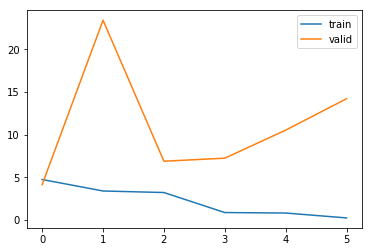

In [26]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

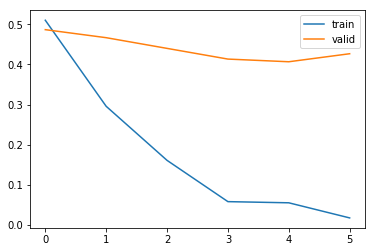

In [27]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])